In [2]:
import bvhsdk
import ik
import mathutils
import skeletonmap
import surface
import plotanimation
import egocentriccoord
import numpy as np
import os
from pathlib import Path
import time
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Abstract

Motion Capture is used to record the movements of a real actor and animate virtual characters. It generates intrinsically realistic animations, since it tracks the motion of a real person. But the process to transfer the motion to a character is not straigthforward since the actor and the character may have distinct body proportions and distinct skeleton topology. The present work focus on retargeting the motion from Motion Capture to a 3D character while preserving the spatial relationship betweeen extremity joints, the hands and the feet, and the body surface. This process retain the semantic information information of movements in which the hands and the feet interact with the surface of the body, as holding the hands in front of the eyes or mouth. The Motion Retargeting process described computes new positions of the extremity joints regarding surface components of the body and adapts the pose of the virtual character in the posistions computed using Inverse Kinematics. The motion can be transfered to topologically different skeletons. The results shows that the resulting motion is being adapted accordingly to the body surface and it is as smooth as the original motion capture data.

# Introduction
Toy Story was released in 1995 as the first full length film produced entirely through computer animation techniques<cite data-cite="henne"></cite>. Besides Pixar's production, several applications employ digital animations to entertain, convey information, educate, among others. Some exploits the use of virtual human models to make the human-computer interatction more natural and accessible. Talita, the virtual human of the TAS project<cite data-cite="demartino"></cite>, is a signing avatar that communicates with deaf students using the Brazilian Sign Language. The goal of the TAS project is to help the deaf and hard of hearing to access information and in their educational process.

Humans use not only the voice and facial expression cues to understand intentions, motives and wills, but also the movements of our body and limbs may carry semantic information on the emotion that one is triyng to express. The location, orientation and speed of the hand are some of the parameters that characterizes a sign language gesture, slightly discrepancies will express different messages or even make the gesture unrecognizable. Therefore, an accurate motion representation by the virtual agent should be of great concern.

Keyframing is a technique to animate an avatar, the animator adjusts crucial poses of the 3D character on dispersed frames and an algorithm fills the gap between two poses by interpolating them over time, which creates the impression of the desired motion. Another digital animation technique is Motion Capture (MoCap) that aims to lessen the time-consuming and tedious work of keyframing animations. MoCap systems registers an actor performing the desired motion to animate a 3D character. Optical Motion Capture systems, for example, uses a set of cameras to track the position over time of reflective markers placed on the body surface of the performer. The motion is then transferred to the avatar, the motion retargeting process, without the need to create all the poses along the action.

The motion retargeting, however, can cause ill-conditioned poses when the body proportions of the performer and the avatar are different. The motion retargeting of an actor with long arms covering his ears, as an example, to a 3D character with short arms results in a unrecognizable action, since the hands of the avatar will not reach its ears. In this case, the animator must inspect the animation, identify the irregular artifacts and correct them with keyframing, adjusting the avatar pose to the desired one. Some motion retargeting algorithms aims to avoid such artifacts to further reduce the inspection and adjustments needed by the animator.

Furtheremore, the standard approach to animate 3D characters is the skeleton animation. The skeleton, a hierarchical structure of joints and bones, stores the actual motion data and the surface of the character is deformed accordingly to the rotation and translation of the skeleton. Often MoCap systems, game engines, 3D modeling and animation software built the skeleton with different specifications(cite Kitagawa), i.e., distinct topologies of the hierarchical structure. This complicates the motion retargeting process because the joints and bones of one skeleton may not exist in another or be represented in another way.



# Workflow
![Workflow](../figures/Workflow3.png)

# Initial Retargeting

## Skeleton Animation
This chapter describes the Initial Motion Retargeting process, which receives the source animation and the target skeleton as inputs, both BVH files. The output is an animation of the target skeleton performing the movements of the source skeleton that can be exported as a BVH file. The success of the process does not depend on matching topologies of the skeletons, but the first pose of the source animation and the target skeleton pose must be as close as possible to the T-Pose. The output of the Initial Retargeting is the target skeleton animation. The target animation does not exploit yet the “surface-awareness” adjustments that the methods described in the subsequent sections provide, but it can already be imported in game engines or animation softwares to animate a 3D character.


To animate a skeleton, its joints must rotate and translate along the frames, conveying the impression of motion. The hierarchical representation of the skeleton allows an all-around description of the motion by only preserving the rotational and translational values of a joint regarding its parent joint, i.e., local rotations and translations. The local transform matrix $M$ is the combination of both rotation $R$ and translation matrix $T$:

\begin{equation}
\label{eq:transformmatrix}
M = TR = \begin{bmatrix}
    R_{3x3} & T \\
    0 & 1
    \end{bmatrix}
\end{equation}

Given a joint $n$ in the skeleton, its global transform matrix $M_{global}^{n}$ is the combination of the local transform matrices of all the joints above the hierarchy. The position of the joint is computed through the global transform matrix.

\begin{equation}
\label{eq:transformmatrixglobal}
M_{global}^{n} = \prod_{i=0}^{n} M_{local}^{i}
\end{equation}

\begin{equation}
\label{eq:position}
\mathbf{p}_{n} = M_{global}^{n}[0,0,0,1]^T
\end{equation}

In [3]:
#Load Source Animation (Skeleton + Motion)
#sourceAnimationPath = '..\data\source_animation-entender.bvh'
sourceAnimationPath = Path("../data/source_animation-boca.bvh")
sourceAnimation = bvhsdk.ReadFile(sourceAnimationPath)
#Load Target Skeleton
targetSkeleton = Path("../data/target_skeleton.bvh")
targetAnimation = bvhsdk.ReadFile(targetSkeleton)
#Load Source Surface
sourceSurfacePath = Path("../data/source_surface.txt")
sourceSurface = surface.GetMoCapSurfaceFromTXT(sourceSurfacePath, highpolymesh = False)
#Load Target Surface
targetSurfacePath = Path("../data/target_surface.csv")
targetSurface = surface.GetAvatarSurfaceFromCSV(targetSurfacePath, targetAnimation, False)

The mapping was successful


In [4]:
def PlotBVH(animation):           
    %matplotlib qt
    def update(frame, lines, bones):
        for line, bone in zip(lines, range(len(lines))):
            line.set_data([bones[frame,bone,0], bones[frame,bone,3]], [bones[frame,bone,1], bones[frame,bone,4]])
            line.set_3d_properties([bones[frame,bone,2], bones[frame,bone,5]])
        return lines

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    #print('Preparing plot:')
    #print('Computing Bones...')
    #Draw Bones #######################################################
    bones = []
    for frame in range(animation.frames):
        bones.append(animation.getBones(frame))
        #if np.mod(frame+1,100) == 0:
            #print('%i frames done.' % (int((frame+1)/100)*100))
        
    bones = np.asarray(bones)
    mindata = bones.min()
    maxdata = bones.max()
    lines = []
    for bone in animation.getBones(0):
        lines.append(ax.plot([bone[0], bone[3]], [bone[1], bone[4]], [bone[2], bone[5]],'-o', color='black')[0])
    #print('Done!')
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(mindata,maxdata)
    ax.set_ylim(mindata,maxdata)
    ax.set_zlim(mindata,maxdata)
    ani = FuncAnimation(fig, update, frames=np.arange(animation.frames), fargs=(lines, bones) ,interval=1, blit=True)
    return ani


In [5]:
#Plot Source Animation (it may take a minute)
#_ = PlotBVH(sourceAnimation)

## Skeleton Mapping

Figure 2 presents two approaches to represent a virtual human skeleton. Although both can animate a humanoid-shaped model, transferring motions between the skeletons is not straightforward. A correspondence between joints of the skeletons is mandatory to identify which joints from the target skeleton should mimic the motion from the source skeleton. It is possible to infer a correspondence using the joints’ name automatically, but note that they may not be placed at the same point in the respective skeleton, as the shoulders in the figure. Therefore, the user can provide a correspondence between skeletons to properly map joints and to perform the motion retargeting (Detailed in Appendix A) (cite Monzani and Hsieh).

![Skeleton Map](../figures/skelmap.png)

In this work, it is required that both target and source skeletons have at least the set of joints: one hips joint, three spine joints, neck and head joints, and right and left joints for the shoulders, elbows, wrists, femurs, knees and feet. The joints referenced will be the only ones used in the Initial Retargeting proccess.

## Bones Alignment

Bones Alignment enforces that the vector of a mapped joint from the target skeleton pointing towards its child joint has the same direction of the correspondent vector from the source skeleton. Then, for every frame, we apply the same transform from the source skeleton joint to the correspondent target joint.

The rotation matrix $R_{A}$ to align the bone vector of the target skeleton onto the bone vector of the source skeleton is calculated and applied to the global rotation of the target skeleton joint $R_{NG}^{n}$:

\begin{equation}
        \label{eq:newglobal}
        R_{NG}^{n} = R_{A} R_{G}^{n}
        \end{equation}
        
Then, as expected by the BVH file format, we recover the local rotation of the joint $R_{L}^{n}$, the new global orientation is multiplied by its parent inverse rotation matrix.

\begin{equation}
        \label{eq:newglobal2}
        R_{NG}^{n} = \left(\prod_{i=0}^{n-1} R_{L}^{i}\right) R_{L}^{n} 
        \end{equation}

\begin{equation}
    \label{eq:newglobal3}
    R_{NG}^{n} = R_{G}^{n-1} R_{L}^{n}
    \end{equation}
        
\begin{equation}
    \label{eq:newglobal4}
    R_{L}^{n} = (R_{G}^{n-1})^{-1} R_{NG}^{n}
    \end{equation}
    
In the following frames, the rotation of a joint in the source animation, from the last frame to the current one, replaces the rotation $R_{A}$ to align the correspondent joint in the target skeleton.

The source motion of the root joint is decomposed into vertical and horizontal movement that are analyzed separately. The horizontal movement is the projection of the root joint position into the ground, the reason of the decomposition is the use of this projected point as a reference point for the feet (Section Surface Characterization).

The ratio is given by:

\begin{equation}
    \label{eq:heightratio}
    ratio = \frac{h_{root}^{tgt}}{h_{root}^{src}}
    \end{equation}
    
where $h_{root}^{tgt}$ and $h_{root}^{src}$ are the heights of the root joint of the target and source skeletons in the first frame. The horizontal and vertical movement of the root, $g(t)$ and $h(t)$ is computed. The translation of the root joint regarding the system origin is equal to these values recombined.

\begin{equation}
    \label{eq:rootmov}
    \mathbf{g}(t)_{root}^{src} = \mathbf{g}(t)_{root}^{tgt} ratio \hspace{10pt} and \hspace{10pt}
    \mathbf{h}(t)_{root}^{src} = \mathbf{h}(t)_{root}^{tgt} ratio
    \end{equation}

In [8]:
def AlignBones(tgtAnim, srcAnim, headAlign = True, spineAlign = True, handAlign = True):
    """
    Align the bones of the target skeleton with the bones of the source skeleton.

    Parameters
    ----------
    target : Animation class object
        Input target skeleton. An Animation object with one frame. The skeleton should be in the T-Pose.
    source : Animation class object
        Input source animation. An Animation object that the target skeleton will copy.
    headAlign : bool, optional
        If this is set to True, the neck bone is aligned. This can cause strange looking pose if the skeletons have very different topologies.
    spineAlign : bool, optional
        If this is set to True, the spine bone is aligned. This can cause strange looking pose if the skeletons have very different topologies.
    """
    #Get mapping
    srcmap = srcAnim.getskeletonmap()
    tgtmap = tgtAnim.getskeletonmap()
    #
    #Save the reference TPose
    for joint in tgtAnim.getlistofjoints():
        joint.tposerot = joint.rotation[0]
        joint.tposetrans = joint.translation[0]
    start=time.time()
    #Expand the number of frames of the avatar animation to match the mocap animation
    tgtAnim.expandFrames(srcmap.root.translation.shape[0])
    #Adapt pose each frame
    print('Starting Posture Initialization')
    for frame in range(srcAnim.frames):
        if np.mod(frame+1,100) == 0:
            print('%i frames done. %s seconds.' % (int((frame+1)/100)*100,time.time()-start))
            start=time.time()
        #Get the Height of the root in the base position (Frame = 0)
        #If the source animation (mocap) is not in the TPose, it will fail
        if frame == 0:
            ground_normal = np.array([0,1,0])
            srcHHips = np.dot(srcmap.hips.getPosition(0), ground_normal)
            tgtHHips = np.dot(tgtmap.hips.getPosition(0), ground_normal)
            ratio = tgtHHips/srcHHips
        #Adjust roots/hips height
        #Eray Molla Eq 1
        srcPosHips = srcmap.hips.getPosition(frame)
        srcGroundHips = np.asarray([srcPosHips[0], 0, srcPosHips[2]])
        tgtGroundHips = srcGroundHips*ratio
        srcHHips = np.dot(srcmap.hips.getPosition(frame), ground_normal)
        tgtHHips = srcHHips*ratio
        tgtmap.root.translation[frame] = [0,tgtHHips,0] + tgtGroundHips
        if frame == 0:
            srcBones = []
            tgtBones = []
            if spineAlign:
                srcBones.append([srcmap.hips, srcmap.spine3])
                tgtBones.append([tgtmap.hips, tgtmap.spine3])
            if headAlign:
                srcBones.append([srcmap.neck, srcmap.head])
                tgtBones.append([tgtmap.neck, tgtmap.head])
            srcBones = srcBones + [[srcmap.rarm, srcmap.rforearm],[srcmap.larm, srcmap.lforearm],[srcmap.rforearm, srcmap.rhand],[srcmap.lforearm, srcmap.lhand],[srcmap.rupleg, srcmap.rlowleg],[srcmap.lupleg, srcmap.llowleg],[srcmap.rlowleg, srcmap.rfoot],[srcmap.llowleg, srcmap.lfoot]]
            tgtBones = tgtBones + [[tgtmap.rarm, tgtmap.rforearm],[tgtmap.larm, tgtmap.lforearm],[tgtmap.rforearm, tgtmap.rhand],[tgtmap.lforearm, tgtmap.lhand],[tgtmap.rupleg, tgtmap.rlowleg],[tgtmap.lupleg, tgtmap.llowleg],[tgtmap.rlowleg, tgtmap.rfoot],[tgtmap.llowleg, tgtmap.lfoot]]
            if handAlign and srcmap.lhandmiddle and srcmap.rhandmiddle and tgtmap.lhandmiddle and tgtmap.rhandmiddle:
                srcBones = srcBones + [[srcmap.rhand, srcmap.rhandmiddle],[srcmap.lhand, srcmap.lhandmiddle]]
                tgtBones = tgtBones + [[tgtmap.rhand, tgtmap.rhandmiddle],[tgtmap.lhand, tgtmap.lhandmiddle]]
            for srcBone, tgtBone in zip(srcBones,tgtBones):
                #Get source and target global transform and rotation matrices from the start of the bone
                p0 = srcBone[0].getPosition(0)
                p1 = srcBone[1].getPosition(0)
                srcDirection = mathutils.unitVector(p1-p0)
                #Get source and target global transform and rotation matrices from the end of the bone
                p0 = tgtBone[0].getPosition(0)
                p1 = tgtBone[1].getPosition(0)
                tgtDirection = mathutils.unitVector(p1-p0)
                #Align vectors
                alignMat = mathutils.alignVectors(tgtDirection, srcDirection)
                #Get new global rotation matrix
                tgtGlbTransformMat = tgtBone[0].getGlobalTransform(frame)
                tgtGlbRotationMat = mathutils.shape4ToShape3(tgtGlbTransformMat)
                tgtNewGblRotationMat = np.dot(alignMat,tgtGlbRotationMat)
                #Get new local rotation matrix
                if not tgtBone[0] == tgtmap.root: #Does not have a parent, transform is already local
                    tgtParentGblRotationMat = mathutils.shape4ToShape3(tgtBone[0].parent.getGlobalTransform(frame))
                    tgtNewLclRotationMat = np.dot(tgtParentGblRotationMat.T, tgtNewGblRotationMat)
                else:
                    tgtNewLclRotationMat = tgtNewGblRotationMat[:]
                #Get new local rotation euler angles
                tgtNewLclRotationEuler, warning = mathutils.eulerFromMatrix(tgtNewLclRotationMat, tgtBone[0].order)
                tgtBone[0].rotation[frame] = tgtNewLclRotationEuler

        else:
            for tgtJoint, srcJoint in zip(tgtmap.getJointsNoRootHips(), srcmap.getJointsNoRootHips()):
                if tgtJoint is not None and srcJoint is not None:
                    previousframe = frame-1 if frame!= 0 else 0
                    #Get source and target global transform and rotation matrices
                    #Even if frame == 0 the matrices need to be recalculated
                    srcGlbTransformMat = srcJoint.getGlobalTransform(frame)
                    srcGlbRotationMat = mathutils.shape4ToShape3(srcGlbTransformMat)
                    tgtGlbTransformMat = tgtJoint.getGlobalTransform(previousframe)
                    tgtGlbRotationMat = mathutils.shape4ToShape3(tgtGlbTransformMat)
                    #Get previous source global transform and rotation matrices
                    srcPreviousGlbTransformMat = srcJoint.getGlobalTransform(previousframe)
                    srcPreviousGlbRotationMat = mathutils.shape4ToShape3(srcPreviousGlbTransformMat)
                    #Get the transform of the source from the previous frame to the present frame
                    transform = np.dot(srcGlbRotationMat, srcPreviousGlbRotationMat.T)
                    #Apply transform
                    tgtNewGblRotationMat = np.dot(transform, tgtGlbRotationMat)
                    #Get new local rotation matrix
                    tgtParentGblRotationMat = mathutils.shape4ToShape3(tgtJoint.parent.getGlobalTransform(frame))
                    tgtNewLclRotationMat = np.dot(tgtParentGblRotationMat.T, tgtNewGblRotationMat)
                    #Get new local rotation euler angles
                    tgtNewLclRotationEuler, warning = mathutils.eulerFromMatrix(tgtNewLclRotationMat, tgtJoint.order)
                    tgtJoint.rotation[frame] = tgtNewLclRotationEuler[:]
    tgtAnim.frames = srcAnim.frames
    tgtAnim.frametime = srcAnim.frametime
    
#Perform the initial retargeting
AlignBones(targetAnimation, sourceAnimation)
targetAnimation_aligned = deepcopy(targetAnimation)

Starting Posture Initialization
100 frames done. 16.90891742706299 seconds.
200 frames done. 15.871538877487183 seconds.
300 frames done. 16.89755892753601 seconds.
400 frames done. 15.213846445083618 seconds.
500 frames done. 15.43212604522705 seconds.
600 frames done. 13.708704233169556 seconds.
700 frames done. 16.57610034942627 seconds.
800 frames done. 17.08201766014099 seconds.
900 frames done. 16.121678113937378 seconds.


In [ ]:
#Plot Target Animation (this may take a few minutes)
#_ = PlotBVH(targetAnimation)

# Surface Characterization

## Surface Calibration

Molla defined a set of points to characterize the surface of the 3D model’s and performer’s body, the yellow dots on Figure 5.1.  The points are connected throughtriangles to create a mesh that represents the body surface. The points on the surfaceof the character and the performer need to be collected as close to the relative positionas possible, since the triangle mesh differences between the characters must represent differences of the characters’ surface, thus sampling surface points from different placesintroduces noise to the analysis. The thickness of the limbs are also registered and later they are represented by capsules to avoid self-penetration in the animation.

![Character Surface Calibration](../figures/TalitaPoints.png)

The user obtains the surface points and radius of each limb of the character during its creation or through a 3D modeling software.


## Surface Motion Estimation

Collecting the position of the surface points is not enough because the performer may walk around, jump or simply twist his torso. In those cases, the sampled points do not represent the current surface position, since we do not keep track of these points. To include the surface deformation - translation and twist effects - we attach each calibration point representing the character mesh (yellow dots in Figure) to the nearest mapped joint. Thus, the point behaves as a child of the mapped joint and the transformations from every joint in the hierarchy is also applied to the point.


## Computing Egocentric Coordinates
We compute the egocentric coordinates of each limb joint in respect to each triangle in the surface mesh and for each capsule limb. Molla computes the projection of the joint's position $\mathbf{p}$ on the $m$ triangles of the mesh, the projected point $\mathbf{x}$ is called the reference point, and the displacement vector $\mathbf{v}$ is the distance of the joint's position to the reference point. Then, the position of joint $n$ regarding the surface component $i$ is expressed as the equation: 

\begin{equation}
\label{eq:egocoord_jointpos1}
\mathbf{p}_n = \mathbf{x}_i + \mathbf{v}_i
\end{equation}
        
The position is expressed likewise for the limbs, but the reference point is the intersection between the capsule surface and the line that passes through the center of the capsule and the joint's position. Then, combining all the surface components, limbs and meshes, the previous equation becomes:

\begin{equation}
\label{eq:egocoord_jointpos2}
\mathbf{p}_n = \sum_{i=1}^{m}\hat{\lambda}_{i}(\mathbf{x}_i + \mathbf{v}_i)
\end{equation}

The importance factor $\lambda$ of a surface component is metric that encodes the proximity and orthogonality between the component and the joint's position. The goal of the importance factor is allow that surface components that are near and more perpendicular to the joint have a higher contribution on the joint's position calculation.

Furthermore, a small distance between the joint and the surface may indicate that a interaction is occurring, covering the eyes with the hand as an example. In this case, we desire that the weights of the hand position that a surface component in head express excel the weights of the torso surface component, in order to preserve the interaction between the head and not with the torso. 

The importance factor of a surface component is the combination of the proximity $\lambda_p$ and the orthogonality $\lambda_{\perp}$ properties:

\begin{equation}
\label{eq:importance}
\lambda = \lambda_p \lambda_{\perp}\hspace{0.1cm},\hspace{0.2cm} with \hspace{0.5cm}\lambda_p =  \frac{1}{||\mathbf{v}||}\hspace{0.5cm} and \hspace{0.5cm}\lambda_{\perp} = cos(\alpha)
\end{equation}

    
where $\alpha$ is the angle between the displacement vector $\mathbf{v}$ and the surface component normal. Finally, $\hat{\lambda}_{i}$ is computed as

\begin{equation}
\label{eq:importance_ortho}
\hat{\lambda}_{i} = \frac{\lambda_{i}}{\sum_{j=1}^{m}\lambda_{j}}
\end{equation}
    
Using the target character surface information to compute the reference points and the displacement vectors from the source skeleton, and reversing Equation, we obtain the position for a target skeleton joint with the same distance from its surface as the source skeleton distance from its respective surface. But differences in the body proportions and bones length between the skeletons still were not taken into account, which will result in odd-looking poses or in a position impossible to reach.



In [9]:
def importanceCalc(dispvector, normal, handthick = 3.5):
        """
        Computes the importance factor for the surface mesh component with normal = normal from the 
        joint with displacement vector = dispvector. We consider the hand thickness of the motion
        capture system: you can estimate it by asking the MoCap performer to put both hands close
        to each other (like praying), calculating the distance from each joint and dividing by 2.
        You can also set it to zero.
        You can change the handling of negative values equation to the one proposed by Eray Molla 
        (or your own) to compare results.
        """
        epsilon = 0.01
        #Proximity importance calculation (considering hand thickness colected from the motion capture system)
        normdispvector = np.linalg.norm(dispvector)-handthick
        #Handling numerical instability
        if normdispvector <= epsilon:
            proximity = 1/epsilon
        else:
            proximity = 1/normdispvector
        normal_unit = normal/np.linalg.norm(normal)
        dispvector_unit = dispvector/normdispvector
        #Orthogonality importance calculation
        #Calculating cosine
        orthogonality = np.clip(np.dot(normal_unit, dispvector_unit), -1.0, 1.0)
        #Handling negative values
        orthogonality = (orthogonality+1)/2
        #Handling numerical instability
        if orthogonality < epsilon:
            orthogonality = epsilon
        orthogonality = np.abs(orthogonality)
        return orthogonality*proximity, orthogonality, proximity

## Kinematic Path Normalization
Molla proposes the Kinematic Path Normalization to adjust the joints' position according to the length of the bones in the skeleton. The kinematic path is the route through joints and bone segments from a reference point to a limb joint. Figure BLA represents the kinematic path for the right hand to the root.

Note that the goal of the Kinematic Path Normalization is to adjust the position of the joint accordingly to the length of the bone segments. Thus, since the source and target skeleton may have different topologies, we consider a set of bone segments that can be mapped between skeleton with distinct levels of details. This set of bones represent a basic skeleton with the bones: spine, head, and right and left clavicle, arm, forearm, femur, thight and shin.

Given the path along the skeleton from the joint being evaluated until the nearest joint of the surface component or until the extremity joint for limbs capsules, we compute the displacement vector as

\begin{equation}
\label{eq:dispvector}
\mathbf{v} = \mathbf{-x}_{j0} + \sum_{i=1}^{n} \mathbf{s}_i
\end{equation}

<img src="../figures/SkeletonKinematicPath.svg" alt="drawing" width="300"/>


Molla computes the contribution of each bone segment $\mathbf{s}_i$ in the kinematic path to the position of the joint relative to the surface, that is, the displacement vector $\mathbf{v}$, based on the projection of each bone vector onto the displacement vector by

\begin{equation}
\label{eq:contribution}
cos(\alpha_{i}) = \frac{\mathbf{v}}{||\mathbf{v}||}\cdot\frac{\mathbf{s}_{i}}{||\mathbf{s}_{i}||}
\end{equation}

The cosines of every bone in the kinematic path are kept as $C_{i} = \{|cos(\alpha_{1})|, |cos(\alpha_{2})|,..., |cos(\alpha_{n})|\}$ for a kinematic path with $n$ bone segments. To adapt the joint position in the target skeleton, the displacement vector is normalized as

\begin{equation}
\label{eq:tau}
\mathbf{\hat{v}} = \frac{\mathbf{v}}{\tau},\ where\ \tau = \sum_{i=0}^{n}||\mathbf{s}_{i}||\ |cos(\alpha_{i})|
\end{equation}

## Summary
Given a joint $j$ and a surface component $i$, we store the set of parametes: $\mathbf{e}_{j,i} = (\mathbf{\hat{\lambda}}_{i}$, $\mathbf{\hat{v}}$, $C_{i})$. The egocentric coordinates of a joint $E_{j}$ for a given frame considering all $m$ surface components is given by

\begin{equation}
\label{eq:egocoordsall}
E_{j} = \{e_{j,1}, e_{j,2},...,e_{j,m}\}
\end{equation}

In [10]:
def pathnormCalc(joint, animation, mesh, frame, refpoint, vectors, surface = None):
    """
    Computes the kinematic path normalization for each limb joint (hands, elbows, knees and feet).
    The foot contact with the ground will be included in future versions.
    
    Parameters
    ----------
    joint : 
    animation : 
    mesh : 
    frame : 
    refpoint : 
    vectors : 
    surface : 
    """
    #Get bone vectors
    lvec_fore, rvec_fore, lvec_arm, rvec_arm, lvec_clavicle, rvec_clavicle, vec_neck, vec_spine, lvec_femur, rvec_femur, lvec_upleg, rvec_upleg, lvec_lowleg, rvec_lowleg = vectors
    #Get mapped joints
    lhand, rhand, lforearm, rforearm = animation.getskeletonmap().lhand, animation.getskeletonmap().rhand, animation.getskeletonmap().lforearm, animation.getskeletonmap().rforearm
    lfoot, rfoot, llowleg, rlowleg = animation.getskeletonmap().lfoot, animation.getskeletonmap().rfoot, animation.getskeletonmap().llowleg, animation.getskeletonmap().rlowleg
    #Defines the kinematic path for each joint
    if joint == lhand:
        kinpath = np.asarray([lvec_clavicle, lvec_arm, lvec_fore])
    elif joint == rhand:
        kinpath = np.asarray([rvec_clavicle, rvec_arm, rvec_fore])
    elif joint == lforearm:
        kinpath = np.asarray([lvec_clavicle, lvec_arm])
    elif joint == rforearm:
        kinpath = np.asarray([rvec_clavicle, rvec_arm])
    elif joint == lfoot:
        kinpath = np.asarray([lvec_femur, lvec_upleg, lvec_lowleg])
    elif joint == rfoot:
        kinpath = np.asarray([rvec_femur, rvec_upleg, rvec_lowleg])
    elif joint == llowleg:
        kinpath = np.asarray([lvec_femur, lvec_upleg])
    elif joint == rlowleg:
        kinpath = np.asarray([rvec_femur, rvec_upleg])

    #Get vector displacement
    if joint == lhand or joint == rhand or joint == lforearm or joint == rforearm:
        cos = np.empty(len(kinpath)+1)
        #Upper limb
        if mesh == 'head':
            vec_displacement = -(refpoint - animation.getskeletonmap().head.getPosition(frame)) + vec_neck
            vec_displacement = vec_displacement + kinpath.sum(axis = 0)
            cos[0] = mathutils.cosBetween(vec_displacement, vec_neck)
            tau = np.linalg.norm(vec_neck)*cos[0]
        elif mesh == 'body':
            vec_displacement = -(refpoint - animation.getskeletonmap().hips.getPosition(frame)) + vec_spine
            vec_displacement = vec_displacement + kinpath.sum(axis = 0)
            cos[0] = mathutils.cosBetween(vec_displacement, vec_spine)
            tau = np.linalg.norm(vec_spine)*cos[0]
        else:
            raise Exception('Upper limb joints only accept meshes from the head and body.')
        #Get tau (Eray Molla Eq 5)
        for i in range(1,len(cos)):
            cos[i] = mathutils.cosBetween(vec_displacement, kinpath[i-1])
            tau = tau + np.linalg.norm(kinpath[i-1])*cos[i]
    else:
        #Lower limbs
        if mesh == 'head':
            cos = np.empty(len(kinpath)+2)
            vec_displacement = -(refpoint - animation.getskeletonmap().head.getPosition(frame)) + vec_neck - vec_spine
            vec_displacement = vec_displacement + kinpath.sum(axis = 0)
            cos[0] = mathutils.cosBetween(vec_displacement, vec_neck)
            cos[1] = mathutils.cosBetween(vec_displacement, -vec_spine)
            tau = np.linalg.norm(vec_neck)*cos[0] + np.linalg.norm(-vec_spine)*cos[1]
            for i in range(2,len(cos)):
                cos[i] = mathutils.cosBetween(vec_displacement, kinpath[i-2])
                tau = tau + np.linalg.norm(kinpath[i-2])*cos[i]
        elif mesh == 'body':
            cos = np.empty(len(kinpath))
            vec_displacement = -(refpoint - animation.getskeletonmap().hips.getPosition(frame))
            vec_displacement = vec_displacement + kinpath.sum(axis = 0)
            tau = 0
            for i in range(len(cos)):
                cos[i] = mathutils.cosBetween(vec_displacement, kinpath[i])
                tau = tau + np.linalg.norm(kinpath[i])*cos[i]
        elif mesh == 'ground':
            assert joint == rfoot or joint == lfoot, 'Foot contact should only be randled with the right and left foot'
            hipsPosition = animation.getskeletonmap().hips.getPosition(frame)
            hipsGround = np.asarray([hipsPosition[0], 0, hipsPosition[2]])
            hipsHeight = np.asarray([0, hipsPosition[1], 0])
            vec_displacement = -(refpoint - hipsGround) + hipsHeight
            vec_displacement = vec_displacement+ kinpath.sum(axis = 0)
            cos = np.empty(len(kinpath)+1)
            cos[0] = mathutils.cosBetween(vec_displacement, hipsHeight)
            tau = 0
            for i in range(1,len(cos)):
                cos[i] = mathutils.cosBetween(vec_displacement, kinpath[i-1])
                tau = tau + np.linalg.norm(kinpath[i-1])*cos[i]
    return vec_displacement/tau, cos, tau

def GetEgocentricCoordinatesTargets(mocap, surfaceMocap, avatar, surfaceAvatar):
    """
    Get the egocentric coordinates and returns the new positions for each limb joint.
    By default we only compute for the left and right hand joints, you can remove the comments
    in the lines "egocentriccoord.EgocentricCoordinate(joint)" to compute the coordinates and
    targets for the joints you wish, bu it will severely increase the execution time.
    """
    headmesh = surfaceMocap.headmesh
    bodymesh = surfaceMocap.bodymesh
    headmesh_avatar = surfaceAvatar.headmesh
    bodymesh_avatar = surfaceAvatar.bodymesh
    ego = None
    egocentriccoord.EgocentricCoordinate.clean()

    #Get source skeleton map
    mocap_skmap = mocap.getskeletonmap()
    lhand, rhand = mocap_skmap.lhand, mocap_skmap.rhand
    lforearm, rforearm = mocap_skmap.lforearm, mocap_skmap.rforearm
    larm, rarm = mocap_skmap.larm, mocap_skmap.rarm
    lupleg, rupleg = mocap_skmap.lupleg, mocap_skmap.rupleg
    llowleg, rlowleg = mocap_skmap.llowleg, mocap_skmap.rlowleg
    lfoot, rfoot = mocap_skmap.lfoot, mocap_skmap.rfoot

    #Get target skeleton map
    ava_skmap = avatar.getskeletonmap()
    lhand_ava, rhand_ava = ava_skmap.lhand, ava_skmap.rhand
    lforearm_ava, rforearm_ava = ava_skmap.lforearm, ava_skmap.rforearm
    larm_ava, rarm_ava = ava_skmap.larm, ava_skmap.rarm
    lupleg_ava, rupleg_ava = ava_skmap.lupleg, ava_skmap.rupleg
    llowleg_ava, rlowleg_ava = ava_skmap.llowleg, ava_skmap.rlowleg
    lfoot_ava, rfoot_ava = ava_skmap.lfoot, ava_skmap.rfoot

    start=time.time()

    ground_normal = np.asarray([0,1,0])

    egocentriccoord.EgocentricCoordinate(rhand)
    egocentriccoord.EgocentricCoordinate(lhand)
    egocentriccoord.EgocentricCoordinate(rforearm)
    egocentriccoord.EgocentricCoordinate(lforearm)
    egocentriccoord.EgocentricCoordinate(rfoot)
    egocentriccoord.EgocentricCoordinate(lfoot)
    egocentriccoord.EgocentricCoordinate(rlowleg)
    egocentriccoord.EgocentricCoordinate(llowleg)

    #Para cada frame
    for frame in range(mocap.frames):
        if np.mod(frame+1,100) == 0:
            print('%i frames done. %s seconds.' % (int((frame+1)/100)*100,time.time()-start))
            start=time.time()

        vectors = egocentriccoord.getVectors(mocap, frame)
        jointpositions = egocentriccoord.getJointsPositions(mocap, frame)     
        mesh = egocentriccoord.getMeshPositions(mocap, surfaceMocap, frame)
        
        #Para cada junta
        #for joint in [rhand, lhand, rforearm, lforearm, rfoot, lfoot, rlowleg, llowleg]:
        for joint in [rhand, lhand]:
            ego = egocentriccoord.EgocentricCoordinate.getCoord(joint.name).addCoordFrame(frame)
            jointPosition = joint.getPosition(frame)

            #Eray Molla Equation 3
            #Get the surface normal of extrimities joints
            if joint == rhand or joint == lhand or joint == rfoot or joint == lfoot:
                jointSurfaceNormal = egocentriccoord.extremityNormal(mocap, joint, frame)

            #Mesh components
            for i in range(len(bodymesh)+len(headmesh)):
                if i<len(headmesh):
                    refpoint, dispvector, normal = mathutils.distFromCentroid(jointPosition, mesh[i][0], mesh[i][1], mesh[i][2])
                    dispvector_norm, normcoef, tau = pathnormCalc(joint, mocap, 'head', frame, refpoint, vectors, jointpositions)
                else:
                    j = i-len(headmesh)
                    refpoint, dispvector, normal = mathutils.distFromCentroid(jointPosition, mesh[i][0], mesh[i][1], mesh[i][2])
                    dispvector_norm, normcoef, tau = pathnormCalc(joint, mocap, 'body', frame, refpoint, vectors, jointpositions)

                importance, ortho, proxi = importanceCalc(dispvector, normal)
                #Importance
                ego.ortho.append(ortho)
                ego.proxi.append(proxi)
                ego.importance.append(importance)
                #Reference point (triangle mesh)
                ego.refpoint.append(refpoint)
                #Displacement Vector (distance from refpoint to the joint position)
                ego.dispvector.append(dispvector_norm)
                #Cosines between each bone and the displacement vector Eray Molla Eq 4
                ego.normcoef.append(normcoef)
                #Normalization factor Eray Molla Eq 5
                ego.tau.append(tau)
                ego.normal.append(normal)

                #Eray Molla Equation 3
                if joint == rhand or joint == lhand or joint == rfoot or joint == lfoot:
                    angle,_ = mathutils.angleBetween(normal, jointSurfaceNormal)
                    ego.angle.append(angle)

            #Limbs components
            for values_returned in egocentriccoord.pathnormCalcLimb(joint, mocap, 'limb', frame, vectors, jointpositions, surfaceMocap):
                dispvector, normcoef, tau, limbname, normal, refpoint, refpoint_aux = values_returned
                importance, ortho, proxi = egocentriccoord.importanceCalcLimb(vectors, limbname, dispvector, normal)
                ego.ortho.append(ortho)
                ego.proxi.append(proxi)
                ego.importance.append(importance)
                ego.refpoint.append(refpoint)
                ego.dispvector.append(dispvector/tau)
                ego.normcoef.append(normcoef)
                ego.tau.append(tau)
                ego.normal.append(normal)
                #Eray Molla Equation 3
                if joint == rhand or joint == lhand or joint == rfoot or joint == lfoot:
                    angle,_ = mathutils.angleBetween(normal, jointSurfaceNormal)
                    ego.angle.append(angle)

            #Add the ground projection as a reference point
            if joint == rfoot or joint == lfoot:
                refpoint = np.asarray([jointPosition[0], 0,jointPosition[2]])
                dispvector_norm, normcoef, tau = pathnormCalc(joint, mocap, 'ground', frame, refpoint, vectors, jointpositions)
                importance, ortho, proxi = importanceCalc(dispvector, ground_normal)
                ego.ortho.append(ortho)
                ego.proxi.append(proxi)
                ego.importance.append(importance)
                ego.refpoint.append(refpoint)
                ego.dispvector.append(dispvector_norm)
                ego.normcoef.append(normcoef)
                ego.tau.append(tau)
                ego.normal.append(normal)
                angle,_ = mathutils.angleBetween(ground_normal, jointSurfaceNormal)
                ego.angle.append(angle)

            #distance between point p0=jointPosition and line passing through p1 and p2:
            # d = |(p0 - p1) x (p0 - p2)|/|p2-p1|
#            distance = np.linalg.norm(np.cross(jointPosition - p1,jointPosition - p2))/np.linalg.norm(p2 - p1)
#            dispvector = distance - surfaceMocap.getPoint('foreRight').radius

            #Normaliza a importancia
            sumimp = sum(ego.importance)
            ego.importance = np.asarray([ego.importance[element]/sumimp for element in range(len(ego.importance))])


        #####################################################################################
        # Desnormalizando a cada frame
        #####################################################################################

        
        vectors = egocentriccoord.getVectors(avatar, frame)
        jointpositions = egocentriccoord.getJointsPositions(avatar, frame)     
        mesh = egocentriccoord.getMeshPositions(avatar, surfaceAvatar, frame)
        lvec_fore, rvec_fore, lvec_arm, rvec_arm, lvec_clavicle, rvec_clavicle, vec_neck, vec_spine, lvec_femur, rvec_femur, lvec_upleg, rvec_upleg, lvec_lowleg, rvec_lowleg = vectors


        #For each EE (each hand)
        #for joint,egoindex in zip([rhand_ava, lhand_ava, rforearm_ava, lforearm_ava, rfoot_ava, lfoot_ava, rlowleg_ava, llowleg_ava],range(6)):
        for joint,egoindex in zip([rhand_ava, lhand_ava],range(2)):
            #Get the ego coordinates of the mocap animation joint
            # aux_jointname = skeletonmap.getmatchingjoint(joint.name, mocap).name
            ego = egocentriccoord.EgocentricCoordinate.egolist[egoindex].getCoordFrame(frame)

            #For each mesh triangle
            vec_displacement = []
            de_refpoint = []
            position = []
            taulist = []
            normallist = []
            for i in range(len(bodymesh_avatar)+len(headmesh_avatar)):
                if i<len(headmesh_avatar):
                    de_refpoint_aux, normal = mathutils.getCentroid(mesh[i][0], mesh[i][1], mesh[i][2])
                    if joint == lhand_ava: kinpath = np.asarray([vec_neck, lvec_clavicle, lvec_arm, lvec_fore])
                    elif joint == rhand_ava: kinpath = np.asarray([vec_neck, rvec_clavicle, rvec_arm, rvec_fore])
                    elif joint == lforearm_ava: kinpath = np.asarray([vec_neck, lvec_clavicle, lvec_arm])
                    elif joint == rforearm_ava: kinpath = np.asarray([vec_neck, rvec_clavicle, rvec_arm])
                    elif joint == lfoot_ava: kinpath = np.asarray([vec_neck, vec_spine, lvec_femur, lvec_upleg, lvec_lowleg])
                    elif joint == rfoot_ava: kinpath = np.asarray([vec_neck, vec_spine, rvec_femur, rvec_upleg, rvec_lowleg])
                    elif joint == llowleg_ava: kinpath = np.asarray([vec_neck, vec_spine, lvec_femur, lvec_upleg])
                    elif joint == rlowleg_ava: kinpath = np.asarray([vec_neck, vec_spine, rvec_femur, rvec_upleg])
                else:
                    j = i-len(headmesh_avatar)
                    de_refpoint_aux, normal = mathutils.getCentroid(mesh[i][0], mesh[i][1], mesh[i][2])
                    if joint == lhand_ava: kinpath = np.asarray([vec_spine, lvec_clavicle, lvec_arm, lvec_fore])
                    elif joint == rhand_ava: kinpath = np.asarray([vec_spine, rvec_clavicle, rvec_arm, rvec_fore])
                    elif joint == lforearm_ava: kinpath = np.asarray([vec_spine, lvec_clavicle, lvec_arm])
                    elif joint == rforearm_ava: kinpath = np.asarray([vec_spine, rvec_clavicle, rvec_arm])
                    elif joint == lfoot_ava: kinpath = np.asarray([lvec_femur, lvec_upleg, lvec_lowleg])
                    elif joint == rfoot_ava: kinpath = np.asarray([rvec_femur, rvec_upleg, rvec_lowleg])
                    elif joint == llowleg_ava: kinpath = np.asarray([lvec_femur, lvec_upleg])
                    elif joint == rlowleg_ava: kinpath = np.asarray([rvec_femur, rvec_upleg])
                tau = (np.linalg.norm(kinpath, axis = 1)*ego.normcoef[i]).sum()
                vec_displacement_aux = ego.dispvector[i]*tau
                taulist.append(tau)
                vec_displacement.append(vec_displacement_aux)
                de_refpoint.append(de_refpoint_aux)
                position.append(vec_displacement_aux+de_refpoint_aux)
                normallist.append(normal)

            #Get limb coordinates
            for values_returned in egocentriccoord.DenormEgoLimb(joint, avatar, surfaceAvatar, frame, vectors, jointpositions, ego, i+1):
                vec_displacement_aux, de_refpoint_aux, tau, normal = values_returned
                taulist.append(tau)
                vec_displacement.append(vec_displacement_aux)
                de_refpoint.append(de_refpoint_aux)
                position.append(vec_displacement_aux+de_refpoint_aux)
                normallist.append(normal)


            if joint == rfoot_ava or joint == lfoot_ava:
                jointPosition = joint.getPosition(frame)
                hipsPosition = avatar.getskeletonmap().hips.getPosition(frame)
                hipsGround = np.asarray([hipsPosition[0], 0, hipsPosition[2]])
                hipsHeight = np.asarray([0, hipsPosition[1], 0])
                de_refpoint_aux = np.asarray([jointPosition[0], 0, jointPosition[2]])
                if joint == rfoot:
                    kinpath = np.asarray([-de_refpoint_aux, -hipsGround, hipsHeight, rvec_femur, rvec_upleg, rvec_lowleg])
                else:
                    kinpath = np.asarray([-de_refpoint_aux, -hipsGround, hipsHeight, lvec_femur, lvec_upleg, lvec_lowleg])
                vec_displacement_aux = kinpath.sum(axis = 0)
                cos = np.empty(len(kinpath))
                tau = 0
                for i in range(len(cos)):
                    cos[i] = mathutils.cosBetween(vec_displacement_aux, kinpath[i])
                    tau = tau + np.linalg.norm(kinpath[i])*cos[i]
                vec_displacement_aux = ego.dispvector[-1]*tau
                taulist.append(tau)
                vec_displacement.append(vec_displacement_aux)
                de_refpoint.append(de_refpoint_aux)
                position.append(vec_displacement_aux+de_refpoint_aux)
                normallist.append([0,1,0])


            ego.tgt_dispvector = np.asarray(vec_displacement)
            ego.tgt_tau = np.asarray(taulist)
            ego.tgt_refpoint = np.asarray(de_refpoint)
            ego.targets = np.asarray(position)
            ego.tgt_normal = np.asarray(normallist)
    return egocentriccoord.EgocentricCoordinate.egolist#targets, taulist, vec_displacement



In [11]:
#This will take a few minutes
egoCoords = GetEgocentricCoordinatesTargets(sourceAnimation, sourceSurface, targetAnimation, targetSurface)

100 frames done. 66.09921002388 seconds.
200 frames done. 62.49296474456787 seconds.
300 frames done. 65.5607397556305 seconds.
400 frames done. 68.74674415588379 seconds.
500 frames done. 69.0756688117981 seconds.
600 frames done. 67.95900511741638 seconds.
700 frames done. 34.55670380592346 seconds.
800 frames done. 49.882246255874634 seconds.
900 frames done. 67.14527034759521 seconds.


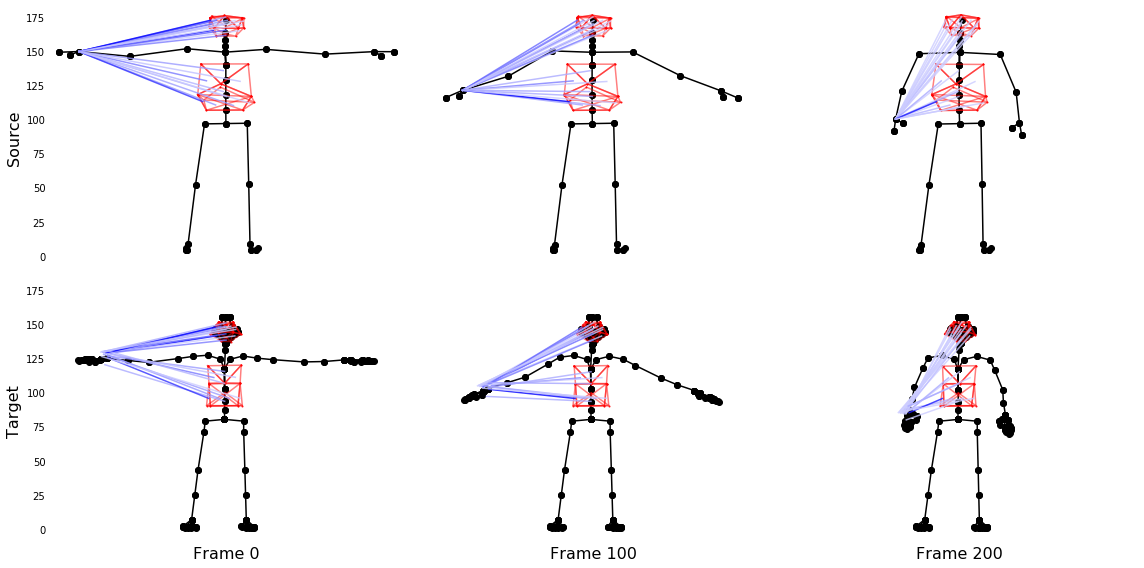

In [12]:
def PlotDispvectorsFrames(srcAnim, srcSurface, tgtAnim, tgtSurface, egoCoord, f1, f2, f3):
    %matplotlib inline
    fig, axs = plt.subplots(2, 3, figsize=(16,8))
    
    min_X, max_X = np.inf,np.NINF
    min_Y, max_Y = np.inf,np.NINF
    for animation, surface, line in zip([srcAnim, tgtAnim],[srcSurface, tgtSurface],range(2)):
        for frame, column in zip([f1,f2,f3],range(3)):
            aux = animation.getBones(frame)
            bones = []
            for i in range(len(aux)):
                axs[line, column].plot([aux[i,0], aux[i,3]], [aux[i,1], aux[i,4]],'-o', color='black')
            surf = []
            for triangle in surface.headmesh:
                vertices = [[vert.getPosition(animation,frame)[0],vert.getPosition(animation,frame)[1]] for vert in triangle]
                vertices.append([triangle[0].getPosition(animation,frame)[0],triangle[0].getPosition(animation,frame)[1]])
                vertices = np.asarray(vertices)
                axs[line, column].plot(vertices[:,0],vertices[:,1],'-o', color='red', markersize=1, alpha = 0.5)

            for triangle in surface.bodymesh:
                vertices = [[vert.getPosition(animation,frame)[0],vert.getPosition(animation,frame)[1]] for vert in triangle]
                vertices.append([triangle[0].getPosition(animation,frame)[0],triangle[0].getPosition(animation,frame)[1]])
                vertices = np.asarray(vertices)
                axs[line, column].plot(vertices[:,0],vertices[:,1],'-o', color='red', markersize=1, alpha = 0.5)
            mini_X,maxi_X = np.min([aux[:,0].min(),aux[:,3].min()]), np.max([aux[:,0].max(),aux[:,3].max()])
            mini_Y, maxi_Y = np.min([aux[:,1].min(),aux[:,4].min()]), np.max([aux[:,1].max(),aux[:,4].max()])
            if mini_X<min_X: 
                min_X=mini_X
            if maxi_X>max_X: 
                max_X=maxi_X
            if mini_Y<min_Y: 
                min_Y=mini_Y
            if maxi_Y>max_Y: 
                max_Y=maxi_Y
                
    lenNoLimb = len(srcSurface.headmesh)+len(srcSurface.bodymesh)
    for frame, column in zip([f1,f2,f3],range(3)):        
        dispvector = np.asarray([np.asarray(egoCoord.framecoord[frame].dispvector[i]*egoCoord.framecoord[frame].tau[i])+egoCoord.framecoord[frame].refpoint[i] for i in range(lenNoLimb)])
        refpoint = np.asarray(egoCoord.framecoord[frame].refpoint[:lenNoLimb])
        norm_importance = egoCoord.framecoord[frame].importance/egoCoord.framecoord[frame].importance.max()
        for i in range(lenNoLimb):
            axs[0, column].plot([refpoint[i,0],dispvector[i,0]],[refpoint[i,1],dispvector[i,1]], color=[np.clip(1*(1-norm_importance[i]),0,0.8),np.clip(1*(1-norm_importance[i]),0,0.8),1,0.8])
        dispvector = np.asarray([np.asarray(egoCoord.framecoord[frame].tgt_dispvector[i])+egoCoord.framecoord[frame].tgt_refpoint[i] for i in range(lenNoLimb)])
        refpoint = np.asarray(egoCoord.framecoord[frame].tgt_refpoint[:lenNoLimb])
        norm_importance = egoCoord.framecoord[frame].importance/egoCoord.framecoord[frame].importance.max()
        for i in range(lenNoLimb):
            axs[1, column].plot([refpoint[i,0],dispvector[i,0]],[refpoint[i,1],dispvector[i,1]], color=[np.clip(1*(1-norm_importance[i]),0,0.8),np.clip(1*(1-norm_importance[i]),0,0.8),1,0.8])
    for line in range(2):
        for column in range(3):
            axs[line, column].set_xlim(min_X-5,max_X+5)
            axs[line, column].set_ylim(min_Y-10,max_Y+10)
            axs[line, column].set_frame_on(False)
            axs[line, column].tick_params(axis='both', which='both', length=0)
            axs[line, column].set_xticks([])
            if column!=0:
                axs[line, column].set_yticks([])
            #axs[line, column].set_axis_off()
    frames = [f1,f2,f3]
    font_size = 16
    for column in range(3):
        axs[1,column].set_xlabel(str.format('Frame %i' % frames[column]), fontsize=font_size)
        
    axs[0,0].set_ylabel('Source', fontsize=font_size)
    axs[1,0].set_ylabel('Target', fontsize=font_size)
    
    plt.tight_layout()
    plt.show()
    
PlotDispvectorsFrames(sourceAnimation, sourceSurface, targetAnimation, targetSurface, egoCoords[0], 0, 100,200)

# Pose Adaptation

To adapt the pose of the target skeleton enforcing the same surface spatial relationship as the souce motion, we denormalize the egocentric coordinates with the parameters regarding the body proportions and bone length of the target skeleton and surface. By inverting Equation \ref{eq:egocoord_jointpos1}, we compute the correct joint position in the target skeleton of a extremity joint, then we use Inverse Kinematics so that the skeleton reaches the new position.

First, we compute the reference point of each mesh component of the target character using the surface estimation from Section Surface Estimation. Then, we use the length of the bone segments to calculate the importance factor $\tau$ for the target skeleton and multiply it by each normalized displacement vector $\mathbf{\hat{v}}_{i}$. Finally, the new position of the joint is given by Equation \ref{eq:egocoord_jointpos2}.


## Inverse Kinematics

We use the Jacobian Transpose method for the Inverse Kinematics (IK) to compute the new pose of the avatar <cite data-cite="buss"></cite>. The kinematic paths fed to the IK algorithm are composed of all joints from the beginning of the limb to the limb extremity: the shoulder to the hand and the upper leg to the foot. This allows a separete IK computing for each limb and avoids dragging the spine and the hips in order to reach the target position.

In [15]:
#Perform Inverse Kinematics for the left and Right hands
#you can remove the comments and perform for all limb joints but it will severely increase the execution time
JacRHand = ik.SimpleJacobian(targetAnimation, targetAnimation.getskeletonmap().rhand, depth = 5)
JacLHand = ik.SimpleJacobian(targetAnimation, targetAnimation.getskeletonmap().lhand, depth = 5)
#JacRElbow = ik.SimpleJacobian(targetAnimation, targetAnimation.getskeletonmap().rforearm, depth = 3)
#JacLElbow = ik.SimpleJacobian(targetAnimation, targetAnimation.getskeletonmap().lforearm, depth = 3)
#JacRFoot = ik.SimpleJacobian(targetAnimation, targetAnimation.getskeletonmap().rfoot, depth = 5)
#JacLFoot = ik.SimpleJacobian(targetAnimation, targetAnimation.getskeletonmap().lfoot, depth = 5)
#JacRKnee = ik.SimpleJacobian(targetAnimation, targetAnimation.getskeletonmap().rlowleg, depth = 3)
#JacLKnee = ik.SimpleJacobian(targetAnimation, targetAnimation.getskeletonmap().llowleg, depth = 3)
#start=time.time()
#print('Starting IK')
for frame in range(targetAnimation.frames):
    _ = JacRHand.jacobianTranspose(frame=frame, target=egoCoords[0].getTarget(frame))
    _ = JacLHand.jacobianTranspose(frame=frame, target=egoCoords[1].getTarget(frame))
    #_ = JacRElbow.jacobianTranspose(frame=frame, target=egoCoords[2].getTarget(frame))
    #_ = JacLElbow.jacobianTranspose(frame=frame, target=egoCoords[3].getTarget(frame))
    #_ = JacRFoot.jacobianTranspose(frame=frame, target=egoCoords[4].getTarget(frame))
    #_ = JacLFoot.jacobianTranspose(frame=frame, target=egoCoords[5].getTarget(frame))
    #_ = JacRKnee.jacobianTranspose(frame=frame, target=egoCoords[6].getTarget(frame))
    #_ = JacLKnee.jacobianTranspose(frame=frame, target=egoCoords[7].getTarget(frame))
    #if np.mod(frame+1,100) == 0:
    #    print('%i frames done. %s seconds.' % (int((frame+1)/100)*100,time.time()-start))
    #    start=time.time()

# Results

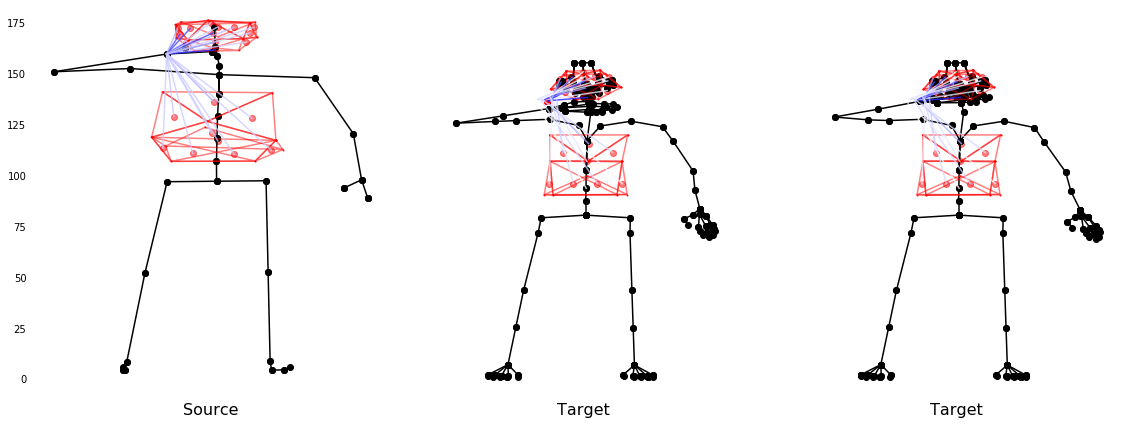

In [16]:
def PlotResults(srcAnim, srcSurface, tgtAnim, tgtAnim_Aligned, tgtSurface, egoCoord, frame):
    %matplotlib inline
    fig, axs = plt.subplots(1, 3, figsize=(16,6))
    min_X, max_X = np.inf,np.NINF
    min_Y, max_Y = np.inf,np.NINF
    for animation, surface, column in zip([srcAnim, tgtAnim_Aligned, tgtAnim],[srcSurface, tgtSurface, tgtSurface],range(3)):
        aux = animation.getBones(frame)
        bones = []
        for i in range(len(aux)):
            axs[column].plot([aux[i,0], aux[i,3]], [aux[i,1], aux[i,4]],'-o', color='black')
        surf = []
        for triangle in surface.headmesh:
            vertices = [[vert.getPosition(animation,frame)[0],vert.getPosition(animation,frame)[1]] for vert in triangle]
            vertices.append([triangle[0].getPosition(animation,frame)[0],triangle[0].getPosition(animation,frame)[1]])
            vertices = np.asarray(vertices)
            axs[column].plot(vertices[:,0],vertices[:,1],'-o', color='red', markersize=1, alpha = 0.5)

        for triangle in surface.bodymesh:
            vertices = [[vert.getPosition(animation,frame)[0],vert.getPosition(animation,frame)[1]] for vert in triangle]
            vertices.append([triangle[0].getPosition(animation,frame)[0],triangle[0].getPosition(animation,frame)[1]])
            vertices = np.asarray(vertices)
            axs[column].plot(vertices[:,0],vertices[:,1],'-o', color='red', markersize=1, alpha = 0.5)
        mini_X,maxi_X = np.min([aux[:,0].min(),aux[:,3].min()]), np.max([aux[:,0].max(),aux[:,3].max()])
        mini_Y, maxi_Y = np.min([aux[:,1].min(),aux[:,4].min()]), np.max([aux[:,1].max(),aux[:,4].max()])
        if mini_X<min_X: 
            min_X=mini_X
        if maxi_X>max_X: 
            max_X=maxi_X
        if mini_Y<min_Y: 
            min_Y=mini_Y
        if maxi_Y>max_Y: 
            max_Y=maxi_Y
                
    lenNoLimb = len(srcSurface.headmesh)+len(srcSurface.bodymesh)
    #Source Animation ego coords:
    dispvector = np.asarray([np.asarray(egoCoord.framecoord[frame].dispvector[i]*egoCoord.framecoord[frame].tau[i])+egoCoord.framecoord[frame].refpoint[i] for i in range(lenNoLimb)])
    refpoint = np.asarray(egoCoord.framecoord[frame].refpoint[:lenNoLimb])
    norm_importance = egoCoord.framecoord[frame].importance/egoCoord.framecoord[frame].importance.max()
    for i in range(lenNoLimb):
        axs[0].plot([refpoint[i,0],dispvector[i,0]],[refpoint[i,1],dispvector[i,1]], color=[np.clip(1*(1-norm_importance[i]),0,0.8),np.clip(1*(1-norm_importance[i]),0,0.8),1,0.8])
        axs[0].scatter(refpoint[i,0], refpoint[i,1], color='red', alpha=0.5)
    #Target Animation ego coords
    dispvector = np.asarray([np.asarray(egoCoord.framecoord[frame].tgt_dispvector[i])+egoCoord.framecoord[frame].tgt_refpoint[i] for i in range(len(egoCoord.framecoord[frame].tgt_refpoint))])
    refpoint = np.asarray(egoCoord.framecoord[frame].tgt_refpoint[:])
    norm_importance = egoCoord.framecoord[frame].importance/egoCoord.framecoord[frame].importance.max()
    for column in range(1,3):
        for i in range(lenNoLimb):
            axs[column].plot([refpoint[i,0],dispvector[i,0]],[refpoint[i,1],dispvector[i,1]], color=[np.clip(1*(1-norm_importance[i]),0,1),np.clip(1*(1-norm_importance[i]),0,1),1,0.8])
            axs[column].scatter(refpoint[i,0], refpoint[i,1], color='red', alpha=0.5)
            target = egoCoord.getTarget(frame)
            axs[column].scatter(target[0], target[1], color='red', marker="X")
    for column in range(3):
        axs[column].set_xlim(min_X-5,max_X+5)
        axs[column].set_ylim(min_Y-10,max_Y+10)
        axs[column].set_frame_on(False)
        axs[column].tick_params(axis='both', which='both', length=0)
        axs[column].set_xticks([])
        if column!=0:
            axs[column].set_yticks([])
        #axs[column].set_axis_off()
    
    font_size = 16
        
    axs[0].set_xlabel('Source', fontsize=font_size)
    axs[1].set_xlabel('Target', fontsize=font_size)
    axs[2].set_xlabel('Target', fontsize=font_size)
    
    plt.tight_layout()
    plt.show()
    
PlotResults(sourceAnimation, sourceSurface, targetAnimation, targetAnimation_aligned, targetSurface, egoCoords[0], 400)

# Conclusion

(Em Construção)

# Future Works

(Em construção)